In [3]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Input
distance  = ctrl.Antecedent(np.linspace(0, 700, 1000), 'DIS')
direction = ctrl.Antecedent(np.linspace(-1,  1, 1000), 'DIR')

infrared0 = ctrl.Antecedent(np.linspace(0,  1, 1000), 'IN0')
infrared1 = ctrl.Antecedent(np.linspace(0,  1, 1000), 'IN1')
infrared2 = ctrl.Antecedent(np.linspace(0,  1, 1000), 'IN2')
infrared3 = ctrl.Antecedent(np.linspace(0,  1, 1000), 'IN3')
infrared4 = ctrl.Antecedent(np.linspace(0,  1, 1000), 'IN4')
infrared5 = ctrl.Antecedent(np.linspace(0,  1, 1000), 'IN5')

deltaNorth = ctrl.Antecedent(np.linspace(-1,  1, 1000), 'DEN')
deltaSouth = ctrl.Antecedent(np.linspace(-1,  1, 1000), 'DES')
deltaEast  = ctrl.Antecedent(np.linspace(-1,  1, 1000), 'DEE')
deltaWest  = ctrl.Antecedent(np.linspace(-1,  1, 1000), 'DEW')

# Output 
rightSpeed = ctrl.Consequent(np.linspace(-50, 50, 1000), 'RSP')
leftSpeed  = ctrl.Consequent(np.linspace(-50, 50, 1000), 'LSP')

/home/tinzog/anaconda3/envs/AI/lib/python3.10/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


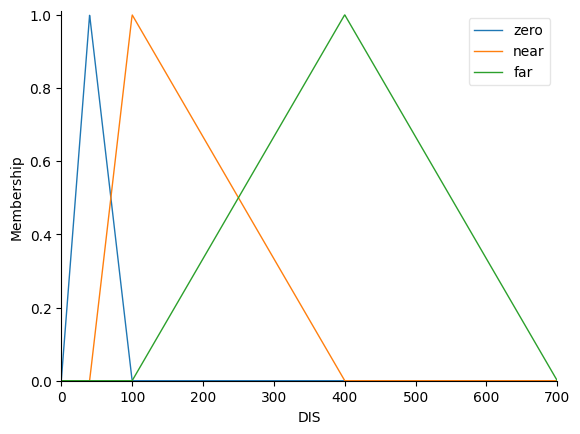

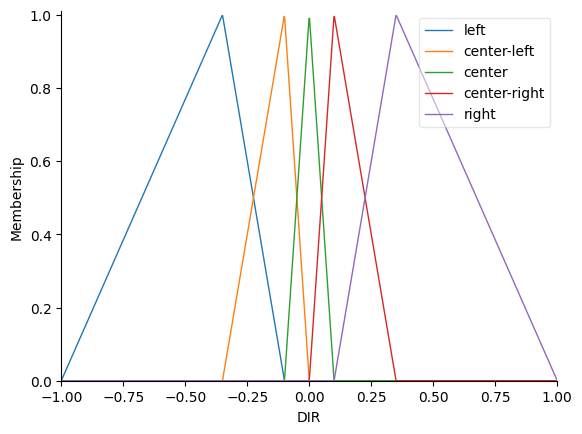

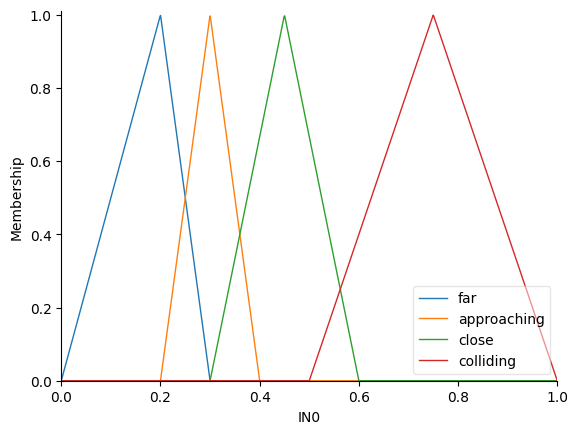

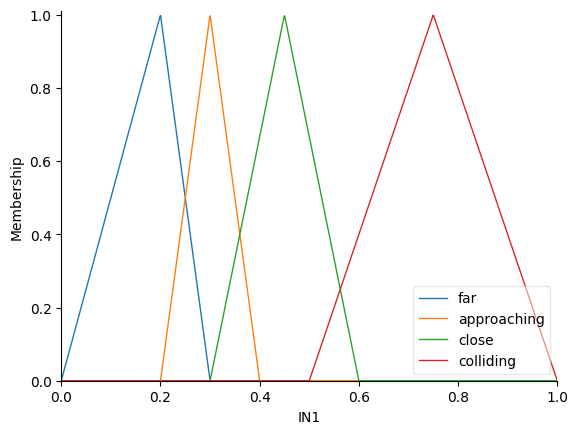

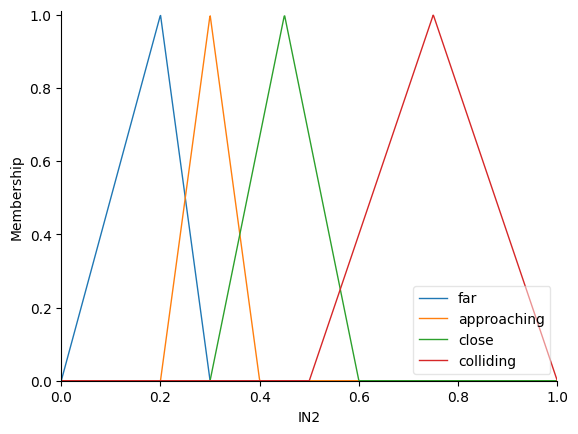

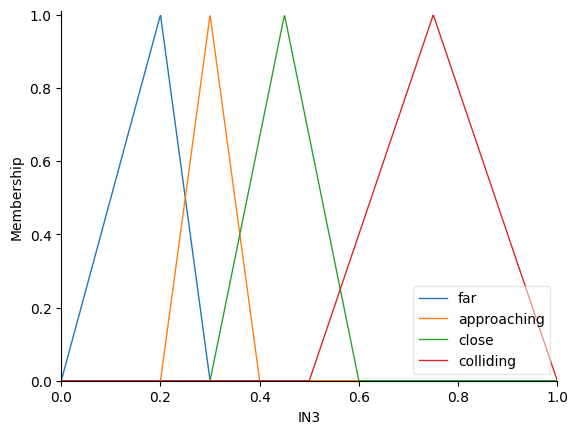

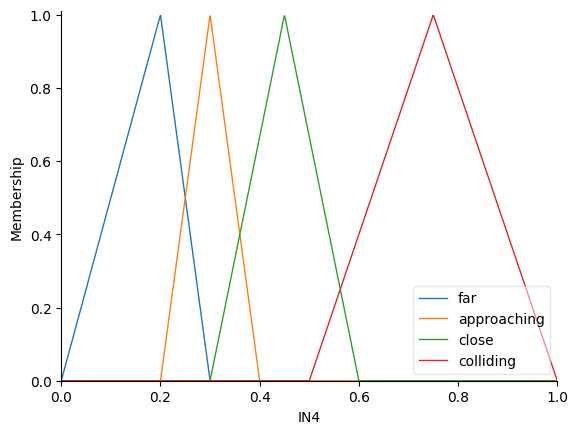

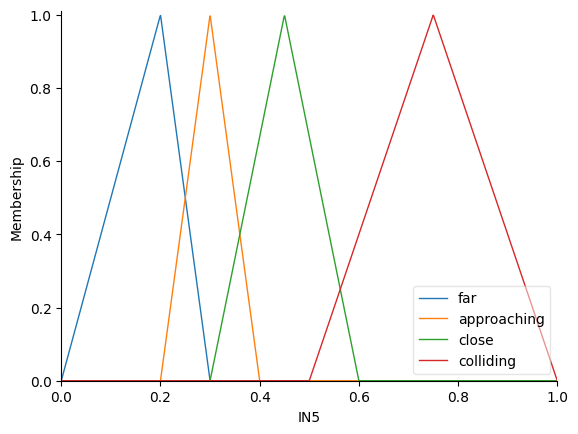

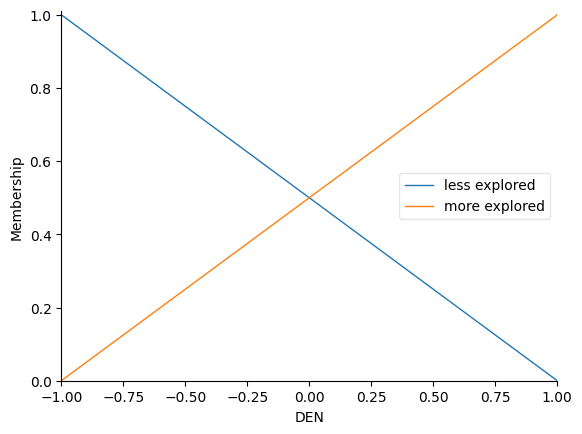

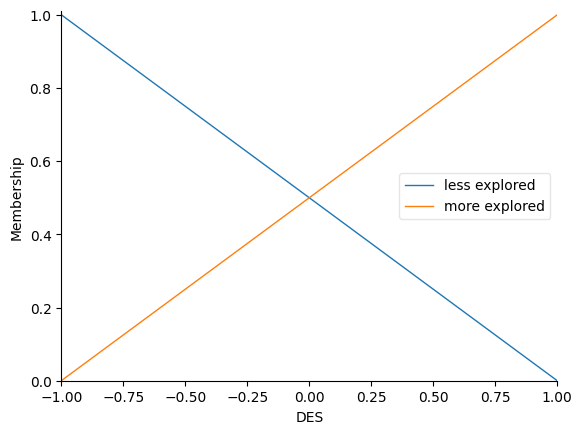

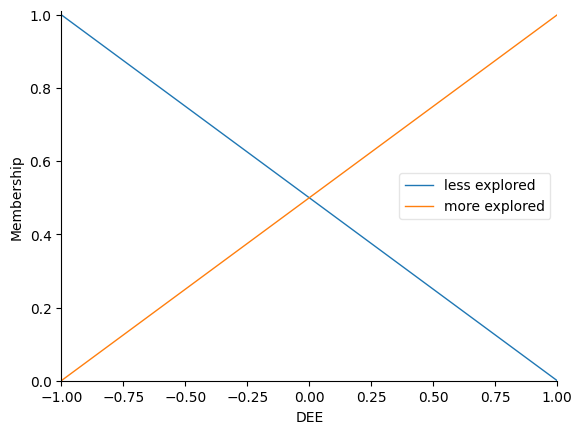

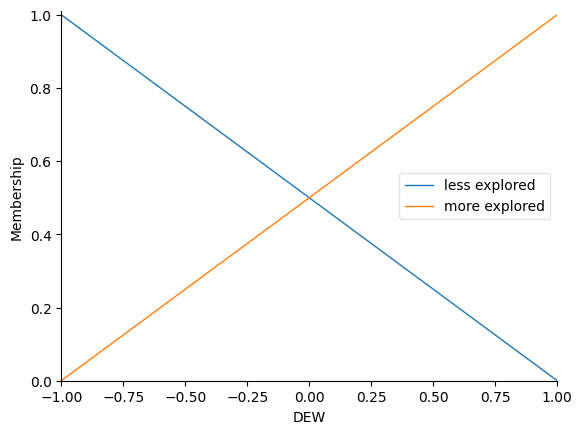

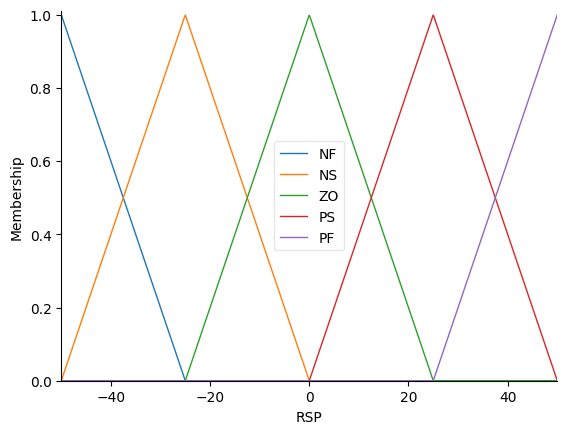

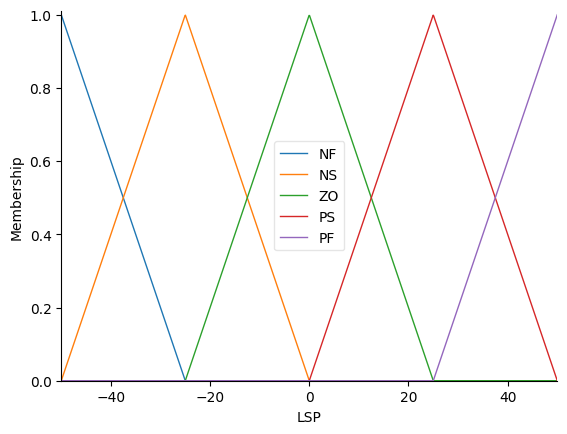

In [5]:
# Membership functions

# Distance
distance['zero'] = fuzz.trimf(distance.universe,[  0,  40, 100])
distance['near'] = fuzz.trimf(distance.universe,[ 40, 100, 400])
distance['far']  = fuzz.trimf(distance.universe,[100, 400, 700])
distance.view()

# Direction
direction['left']         = fuzz.trimf(direction.universe,[   -1, -0.35, -0.1])
direction['center-left']  = fuzz.trimf(direction.universe,[-0.35,  -0.1,    0])
direction['center']       = fuzz.trimf(direction.universe,[ -0.1,     0,  0.1])
direction['center-right'] = fuzz.trimf(direction.universe,[    0,   0.1, 0.35])
direction['right']        = fuzz.trimf(direction.universe,[  0.1,  0.35,    1])
direction.view()

# Infrared
def inf(sensor):
    sensor['far']         = fuzz.trimf(sensor.universe,[  0,  0.2, 0.3])
    sensor['approaching'] = fuzz.trimf(sensor.universe,[0.2,  0.3, 0.4])
    sensor['close']       = fuzz.trimf(sensor.universe,[0.3, 0.45, 0.6])
    sensor['colliding']   = fuzz.trimf(sensor.universe,[0.5, 0.75,   1])
    sensor.view()

inf(infrared0)
inf(infrared1)
inf(infrared2)
inf(infrared3)
inf(infrared4)
inf(infrared5)

# Delta
def delta(delt):
    delt['less explored'] = fuzz.trimf(delt.universe,[-1, -1, 1])
    delt['more explored'] = fuzz.trimf(delt.universe,[-1,  1, 1])
    delt.view()

delta(deltaNorth)
delta(deltaSouth)
delta(deltaEast)
delta(deltaWest)

# Motor
def motor(mot):
    mot['NF'] = fuzz.trimf(mot.universe,[-50, -50, -25])
    mot['NS'] = fuzz.trimf(mot.universe,[-50, -25,   0])
    mot['ZO'] = fuzz.trimf(mot.universe,[-25,   0,  25])
    mot['PS'] = fuzz.trimf(mot.universe,[  0,  25,  50])
    mot['PF'] = fuzz.trimf(mot.universe, [25,  50,  50])
    mot.view()

motor(rightSpeed)
motor(leftSpeed)

In [6]:
FCL1Rule = []

FCL1Rule.append(ctrl.Rule(distance['zero'], (rightSpeed['ZO'], leftSpeed['ZO'])))
FCL1Rule.append(ctrl.Rule(distance['near'] & direction['center'], (rightSpeed['PS'], leftSpeed['PS'])))
FCL1Rule.append(ctrl.Rule(distance['far'] & direction['center'], (rightSpeed['PF'], leftSpeed['PF'])))
FCL1Rule.append(ctrl.Rule(direction['left'], (rightSpeed['NF'], leftSpeed['PF'])))
FCL1Rule.append(ctrl.Rule(direction['center-left'], (rightSpeed['NS'], leftSpeed['PS'])))
FCL1Rule.append(ctrl.Rule(direction['right'], (rightSpeed['PF'], leftSpeed['NF'])))
FCL1Rule.append(ctrl.Rule(direction['center-right'], (rightSpeed['PS'], leftSpeed['NS'])))

#Control system
FCL1_control = ctrl.ControlSystem(FCL1Rule)
FCL1_simulation = ctrl.ControlSystemSimulation(FCL1_control)


In [7]:
FCL2Rule = []

FCL2Rule.append(ctrl.Rule(infrared0['colliding'] | infrared1['colliding'] | infrared2['colliding'], (rightSpeed['NF'], leftSpeed['ZO'])))
FCL2Rule.append(ctrl.Rule(infrared3['colliding'] | infrared4['colliding'] | infrared5['colliding'], (rightSpeed['ZO'], leftSpeed['NF'])))
FCL2Rule.append(ctrl.Rule(infrared0['close'] |  infrared1['approaching'], (rightSpeed['NF'], leftSpeed['PS'])))
FCL2Rule.append(ctrl.Rule(infrared5['close'] |  infrared4['approaching'], (rightSpeed['PS'], leftSpeed['NF'])))
FCL2Rule.append(ctrl.Rule(infrared0['far'] | infrared1['far'] | infrared2['far'] | infrared3['far'] | infrared4['far'] | infrared5['far'], (rightSpeed['PF'], leftSpeed['PF'])))

#Control system
FCL2_control = ctrl.ControlSystem(FCL2Rule)
FCL2_simulation = ctrl.ControlSystemSimulation(FCL2_control)


In [8]:
FCL3Rule = []

FCL3Rule.append(ctrl.Rule(deltaNorth['less explored'] & deltaSouth['less explored'] & deltaEast['less explored'] & deltaWest['less explored'], (rightSpeed['PF'], leftSpeed['PF'])))
FCL3Rule.append(ctrl.Rule(deltaNorth['more explored'], (rightSpeed['PF'], leftSpeed['NF'])))
FCL3Rule.append(ctrl.Rule(deltaSouth['more explored'], (rightSpeed['PF'], leftSpeed['PF'])))
FCL3Rule.append(ctrl.Rule(deltaEast['more explored'], (rightSpeed['PF'], leftSpeed['PF'])))
FCL3Rule.append(ctrl.Rule(deltaWest['more explored'], (rightSpeed['PS'], leftSpeed['NF'])))
#Control system
FCL3_control = ctrl.ControlSystem(FCL3Rule)
FCL3_simulation = ctrl.ControlSystemSimulation(FCL3_control)

In [12]:
FCL1_simulation.input['DIS'] = 60
FCL1_simulation.input['DIR'] = 0.7
FCL1_simulation.compute()
print('FLC1: ',FCL1_simulation.output['RSP'], FCL1_simulation.output['LSP'])

FCL2_simulation.input['IN0'] = 0.1
FCL2_simulation.input['IN1'] = 0.2
FCL2_simulation.input['IN2'] = 0.3
FCL2_simulation.input['IN3'] = 0.4
FCL2_simulation.input['IN4'] = 0.5
FCL2_simulation.input['IN5'] = 0.6
FCL2_simulation.compute()
print('FLC2: ',FCL2_simulation.output['RSP'], FCL2_simulation.output['LSP'])

FCL3_simulation.input['DEN'] = -0.5
FCL3_simulation.input['DEE'] = 0.7
FCL3_simulation.input['DEW'] = -0.8
FCL3_simulation.input['DES'] = 0.6
FCL3_simulation.compute()
print('FLC3: ',FCL3_simulation.output['RSP'], FCL3_simulation.output['LSP'])


FLC1:  11.443922717752983 -11.443922717752844
FLC2:  18.196539338745954 9.883004742837029
FLC3:  36.78948475218498 16.616537173907428
